In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import algos, helpers, envs
from lib.helpers import np_exclude

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm
from joblib import Parallel, delayed
import pickle

/data4/tangsp/venv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
n_ep = 100000
gamma = 0.9
epsilon = 0.9
alpha = 0.5

In [4]:
# ## Deterministic frozenlake 8x8 with intermediate rewards
np.random.seed(42)
env = envs.FrozenLakeEnv_slip_rand_reward(
    map_name="8x8", 
    slip_prob=0.0,
    reward_modifier = [0.000, 0.001, 0.002, 0.003],
)
nS, nA = env.nS, env.nA
S_terminal = env.S_terminal

V_STAR = algos.value_iter(env, gamma=0.9, theta=1e-20)

In [5]:
with open('saved_memory/frozenlake_8x8_rrew.Q.pkl', 'rb') as f:
    metadata = pickle.load(f)
    Q_star = metadata['Qs'][-1] # Q table after the final update
    V_star = Q_star.max(axis=1)

In [6]:
V_star[:5]

array([0.27177751, 0.29992265, 0.32891406, 0.36366007, 0.40073341])

In [7]:
# zeta_range = np.linspace(0, 0.1, 11)
tol = 1e-10

In [8]:
zeta_range = np.linspace(0, 0.1, 21)

## near-greedy

In [ ]:
def run_learn_near_greedy(zeta):
    Q, metadata1 = algos.TD_near_greedy(
        env, n_ep, None, 
        gamma=gamma, zeta=zeta, alpha=alpha,
        Q_star=Q_star, memory=metadata['memory'],
        save_Q=0,
    )
    return Q

In [ ]:
output = Parallel(n_jobs=16)(delayed(run_learn_near_greedy)(zeta) for zeta in tqdm(zeta_range))

In [ ]:
Q_by_zeta = {zeta: Q for zeta, Q in zip(zeta_range, output)}

In [ ]:
pickle.dump(Q_by_zeta, open('baselineQ_lake8x8-near-greedy.p', 'wb'))

In [9]:
Q_by_zeta = pickle.load(open('baselineQ_lake8x8-near-greedy.p', 'rb'))

In [10]:
out = []
for zeta in zeta_range:
    Q = Q_by_zeta[zeta]
    Q_pi, V_pi = helpers.calculate_results(Q, Q_star, zeta, tol)

    df_pi = pd.DataFrame(Q >= (1-zeta-tol) * Q_star.max(axis=1, keepdims=True)).astype(int)
    df_pi.index.name = 'S'
    df_pi.columns.name = 'A'

    avg_pi_size = df_pi.drop(env.S_terminal).sum(axis=1).mean()
    val_pi_est = (1 - np_exclude(V_pi, env.S_terminal) / np_exclude(V_star, env.S_terminal)).max()
    pi = df_pi.values
    V_pi = algos.policy_eval_worst_case(env, pi, gamma=gamma)
    val_pi_PE = (1 - np_exclude(V_pi, env.S_terminal) / np_exclude(V_star, env.S_terminal)).max()
    
    out.append((zeta, avg_pi_size, val_pi_est, val_pi_PE, V_pi.mean()))

In [11]:
df_out_1 = pd.DataFrame(out, columns=['zeta', 'avg_policy_size', 'worst_suboptimality_est', 'worst_suboptimality', 'avg_value'])

In [12]:
df_out_1

,zeta,avg_policy_size,worst_suboptimality_est,worst_suboptimality,avg_value
0,0.000,1.000000,0.000000,0.000000,0.433725
1,0.005,1.188679,0.004694,0.004694,0.433206
2,0.010,1.245283,0.009258,0.009258,0.432206
3,0.015,1.301887,0.014854,0.014854,0.431792
4,0.020,1.358491,0.019927,0.019927,0.431612
5,0.025,1.415094,0.022423,0.022423,0.431514
6,0.030,1.415094,0.022423,0.022423,0.431514
7,0.035,1.415094,0.034273,0.034273,0.431432
8,0.040,1.415094,0.034273,0.034273,0.431432
9,0.045,1.433962,0.040837,0.040837,0.431349


## conservative

In [ ]:
def run_learn_conservative(zeta):
    Q, metadata1 = algos.TD_conservative(
        env, n_ep, None, 
        gamma=gamma, zeta=zeta, alpha=alpha,
        Q_star=Q_star, memory=metadata['memory'],
        save_Q=0,
    )
    return Q

In [ ]:
output = Parallel(n_jobs=16)(delayed(run_learn_conservative)(zeta) for zeta in tqdm(zeta_range))

In [ ]:
Q_by_zeta = {zeta: Q for zeta, Q in zip(zeta_range, output)}

In [ ]:
pickle.dump(Q_by_zeta, open('baselineQ_lake8x8-conservative.p', 'wb'))

In [13]:
Q_by_zeta = pickle.load(open('baselineQ_lake8x8-conservative.p', 'rb'))

In [14]:
out_0 = []
for zeta in zeta_range:
    Q = Q_by_zeta[zeta]
    Q_pi, V_pi = helpers.calculate_results(Q, Q_star, zeta, tol)

    df_pi = pd.DataFrame(Q >= (1-zeta-tol) * Q_star.max(axis=1, keepdims=True)).astype(int)
    df_pi.index.name = 'S'
    df_pi.columns.name = 'A'

    avg_pi_size = df_pi.drop(env.S_terminal).sum(axis=1).mean()
    val_pi_est = (1 - np_exclude(V_pi, env.S_terminal) / np_exclude(V_star, env.S_terminal)).max()
    pi = df_pi.values
    V_pi = algos.policy_eval_worst_case(env, pi, gamma=gamma)
    val_pi_PE = (1 - np_exclude(V_pi, env.S_terminal) / np_exclude(V_star, env.S_terminal)).max()
    
    out_0.append((zeta, avg_pi_size, val_pi_est, val_pi_PE, V_pi.mean()))

In [15]:
df_out_0 = pd.DataFrame(out_0, columns=['zeta', 'avg_policy_size', 'worst_suboptimality_est', 'worst_suboptimality', 'avg_value'])

In [16]:
df_out_0

,zeta,avg_policy_size,worst_suboptimality_est,worst_suboptimality,avg_value
0,0.000,1.0,0.000,0.0,0.433725
1,0.005,1.0,0.005,0.0,0.433725
2,0.010,1.0,0.010,0.0,0.433725
3,0.015,1.0,0.015,0.0,0.433725
4,0.020,1.0,0.020,0.0,0.433725
5,0.025,1.0,0.025,0.0,0.433725
6,0.030,1.0,0.030,0.0,0.433725
7,0.035,1.0,0.035,0.0,0.433725
8,0.040,1.0,0.040,0.0,0.433725
9,0.045,1.0,0.045,0.0,0.433725


## greedify Q*

In [17]:
out_1 = []
for zeta in tqdm(zeta_range):
    Q = Q_star.copy()
    Q_pi, V_pi = helpers.calculate_results(Q, Q_star, zeta, tol)
    
    df_pi = pd.DataFrame(Q >= (1-zeta-tol) * Q_star.max(axis=1, keepdims=True)).astype(int)
    df_pi.index.name = 'S'
    df_pi.columns.name = 'A'
    
    avg_pi_size = df_pi.drop(env.S_terminal).sum(axis=1).mean()
    val_pi_est = (1 - np_exclude(V_pi, env.S_terminal) / np_exclude(V_star, env.S_terminal)).max()
    pi = df_pi.values
    V_pi = algos.policy_eval_worst_case(env, pi, gamma=gamma)
    val_pi_PE = (1 - np_exclude(V_pi, env.S_terminal) / np_exclude(V_star, env.S_terminal)).max()
    
    out_1.append((zeta, avg_pi_size, val_pi_est, val_pi_PE, V_pi.mean()))

100%|██████████| 21/21 [00:01<00:00, 12.37it/s]


In [18]:
df_base1 = pd.DataFrame(out_1, columns=['zeta', 'avg_policy_size', 'worst_suboptimality_est', 'worst_suboptimality', 'avg_value'])

In [19]:
df_base1

,zeta,avg_policy_size,worst_suboptimality_est,worst_suboptimality,avg_value
0,0.000,1.000000,0.000000,0.000000,0.433725
1,0.005,1.245283,0.004694,0.009258,0.433021
2,0.010,1.396226,0.008637,0.022423,0.431559
3,0.015,1.433962,0.013003,0.040837,0.431349
4,0.020,1.433962,0.013003,0.040837,0.431349
5,0.025,1.433962,0.013003,0.040837,0.431349
6,0.030,1.433962,0.013003,0.040837,0.431349
7,0.035,1.433962,0.013003,0.040837,0.431349
8,0.040,1.433962,0.013003,0.040837,0.431349
9,0.045,1.433962,0.013003,0.040837,0.431349


## near-greedy with Q as baseline

In [ ]:
Q_by_zeta = {}
for zeta in zeta_range:
    Q, metadata1 = algos.TD_near_greedy_baseline(
        env, n_ep, None, 
        gamma=gamma, zeta=zeta, alpha=alpha,
        Q_star=None, memory=metadata['memory'],
        save_Q=0,
    )
    Q_by_zeta[zeta] = Q

In [ ]:
def run_learn_near_greedy_baseline(zeta):
    Q, metadata1 = algos.TD_near_greedy_baseline(
        env, n_ep, None, 
        gamma=gamma, zeta=zeta, alpha=alpha,
        Q_star=None, memory=metadata['memory'],
        save_Q=0,
    )
    return Q

In [ ]:
output = Parallel(n_jobs=16)(delayed(run_learn_near_greedy_baseline)(zeta) for zeta in tqdm(zeta_range))

In [ ]:
Q_by_zeta = {zeta: Q for zeta, Q in zip(zeta_range, output)}

In [ ]:
pickle.dump(Q_by_zeta, open('baselineQ_lake8x8-near-baseline.p', 'wb'))

In [20]:
Q_by_zeta = pickle.load(open('baselineQ_lake8x8-near-baseline.p', 'rb'))

In [21]:
out = []
for zeta in zeta_range:
    Q = Q_by_zeta[zeta]
    Q_pi, V_pi = helpers.calculate_results(Q, Q_star, zeta, tol)

    df_pi = pd.DataFrame(Q >= (1-zeta-tol) * Q_star.max(axis=1, keepdims=True)).astype(int)
    df_pi.index.name = 'S'
    df_pi.columns.name = 'A'

    avg_pi_size = df_pi.drop(env.S_terminal).sum(axis=1).mean()
    val_pi_est = (1 - np_exclude(V_pi, env.S_terminal) / np_exclude(V_star, env.S_terminal)).max()
    pi = algos.zeta_optimal_stochastic_policy(Q, dict(Q_star=Q, zeta=zeta, tol=tol))
    V_pi = algos.policy_eval_worst_case(env, pi, gamma=gamma)
    val_pi_PE = (1 - np_exclude(V_pi, env.S_terminal) / np_exclude(V_star, env.S_terminal)).max()
    
    out.append((zeta, avg_pi_size, val_pi_est, val_pi_PE, V_pi.mean()))

/data4/tangsp/ICML2020_RL_SVP/synthetic/lib/helpers.py:144: RuntimeWarning: invalid value encountered in true_divide
  pi = pi / pi.sum(axis=1, keepdims=True)


In [22]:
df_base2 = pd.DataFrame(out, columns=['zeta', 'avg_policy_size', 'worst_suboptimality_est', 'worst_suboptimality', 'avg_value'])

In [23]:
df_base2

,zeta,avg_policy_size,worst_suboptimality_est,worst_suboptimality,avg_value
0,0.000,1.000000,0.000000,0.000000,0.433725
1,0.005,1.169811,0.004694,0.005376,0.433187
2,0.010,1.000000,NaN,0.022423,0.431514
3,0.015,1.169811,NaN,0.022423,0.431514
4,0.020,1.339623,NaN,0.040837,0.431349
5,0.025,1.396226,0.021557,0.040837,0.431349
6,0.030,1.396226,0.021557,0.040837,0.431349
7,0.035,1.415094,0.034273,0.040837,0.431349
8,0.040,1.415094,0.034273,0.040837,0.431349
9,0.045,1.433962,0.040837,0.040837,0.431349


## additive constraint

In [24]:
out_3 = []
for zeta in tqdm(zeta_range):
    margin = (1-gamma) * zeta * np.abs(V_star).max()
    df_pi = pd.DataFrame(Q_star >= Q_star.max(axis=1, keepdims=True) - margin).astype(int)
    df_pi.index.name = 'S'
    df_pi.columns.name = 'A'

    avg_pi_size = df_pi.drop(env.S_terminal).sum(axis=1).mean()
    pi = df_pi.values
    V_pi = algos.policy_eval_worst_case(env, pi, gamma=gamma)
    val_pi_PE = (1 - np_exclude(V_pi, env.S_terminal) / np_exclude(V_star, env.S_terminal)).max()
    
    out_3.append((zeta, avg_pi_size, val_pi_est, val_pi_PE, V_pi.mean()))

100%|██████████| 21/21 [00:00<00:00, 27.35it/s]


In [25]:
df_base3 = pd.DataFrame(out_3, columns=['zeta', 'avg_policy_size', 'worst_suboptimality_est', 'worst_suboptimality', 'avg_value'])

In [26]:
df_base3

,zeta,avg_policy_size,worst_suboptimality_est,worst_suboptimality,avg_value
0,0.000,1.000000,NaN,0.000000,0.433725
1,0.005,1.094340,NaN,0.001034,0.433701
2,0.010,1.132075,NaN,0.002270,0.433670
3,0.015,1.188679,NaN,0.007107,0.433279
4,0.020,1.245283,NaN,0.009628,0.433203
5,0.025,1.301887,NaN,0.015290,0.432838
6,0.030,1.339623,NaN,0.017138,0.432685
7,0.035,1.358491,NaN,0.021487,0.432175
8,0.040,1.396226,NaN,0.039469,0.431450
9,0.045,1.433962,NaN,0.040837,0.431349


## collect results

In [27]:
results = {
    'near-greedy': df_out_1,
    'conservative': df_out_0,
    'Q_star-based': df_base1,
    'Q-based': df_base2,
    'additive': df_base3,
}

In [28]:
pickle.dump(results, open('baseline_lake8x8_all.p', 'wb'))

## Plots

In [29]:
%config InlineBackend.figure_formats = ['svg']

In [30]:
df_p1 = results['near-greedy'].iloc[:-1]
df_p2 = results['conservative'].iloc[:-1]
df_b1 = results['Q_star-based'].iloc[:-1]
df_b2 = results['Q-based'].iloc[:-1]
df_b3 = results['additive'].iloc[:-1]

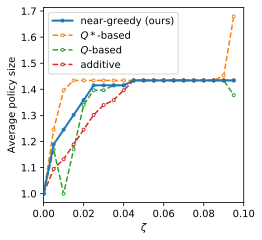

In [31]:
fig, ax = plt.subplots(figsize=(3.6,3.6))
plt.plot(df_p1['zeta'], df_p1['avg_policy_size'], marker='.', zorder=10, lw=2, label='near-greedy (ours)')
# plt.plot(df_p2['zeta'], df_p2['avg_policy_size'], marker='.', mfc='w', ls='--', label='conservative')
plt.plot(df_b1['zeta'], df_b1['avg_policy_size'], marker='.', mfc='w', ls='--', label='$Q*$-based')
plt.plot(df_b2['zeta'], df_b2['avg_policy_size'], marker='.', mfc='w', ls='--', label='$Q$-based')
plt.plot(df_b3['zeta'], df_b3['avg_policy_size'], marker='.', mfc='w', ls='--', label='additive')
# plt.plot([0,0.1], [1,1-0.1], 'k:', label='$(1-\zeta)$ threshold')
plt.legend()
# plt.plot([0,0.1], [0,0.1], 'k:')
plt.xlim(0, 0.1)
# plt.ylim(0.9, 1.005)
plt.xlabel('$\zeta$')
plt.ylabel('Average policy size')
plt.savefig('fig_baseline/polsize_lake8x8rew.pdf', bbox_inches='tight')
plt.show()

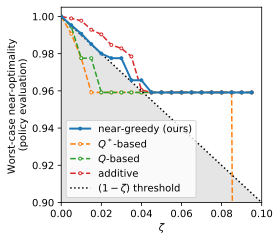

In [32]:
fig, ax = plt.subplots(figsize=(3.6,3.6))
plt.plot(df_p1['zeta'], 1-df_p1['worst_suboptimality'], marker='.', zorder=10, lw=2, label='near-greedy (ours)')
# plt.plot(df_p2['zeta'], 1-df_p2['worst_suboptimality'], marker='.', mfc='w', ls='--', label='conservative')
plt.plot(df_b1['zeta'], 1-df_b1['worst_suboptimality'], marker='.', mfc='w', ls='--', label='$Q^*$-based')
plt.plot(df_b2['zeta'], 1-df_b2['worst_suboptimality'], marker='.', mfc='w', ls='--', label='$Q$-based')
plt.plot(df_b3['zeta'], 1-df_b3['worst_suboptimality'], marker='.', mfc='w', ls='--', label='additive')
plt.plot([0,0.1], [1,1-0.1], 'k:', label='$(1-\zeta)$ threshold')
plt.legend()
ax.fill_between([0,0.1], [0.9,0.9], [1.0,0.9], facecolor='gray', alpha=0.2)
# plt.plot([0,0.1], [0,0.1], 'k:')
plt.xlim(0, 0.1)
plt.ylim(0.9, 1.005)
plt.xlabel('$\zeta$')
plt.ylabel('Worst-case near-optimality \n(policy evaluation)')
plt.savefig('fig_baseline/near-optimality_lake8x8rew.old.pdf', bbox_inches='tight')
plt.show()

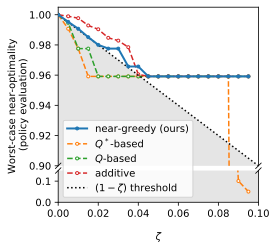

In [33]:
# fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, )
from matplotlib.gridspec import GridSpec
from brokenaxes import brokenaxes

fig = plt.figure(figsize=(3.6,3.6))
gs = GridSpec(5,1)
bax = brokenaxes(xlims=[(0, .1)], ylims=[(0.0, 0.15), (0.9, 1.005)], 
                 hspace=.05, height_ratios=(5,1), despine=False)

# ax = fig.add_subplot(gs[0:4,0])
# ax2 = fig.add_subplot(gs[4:,0])

bax.plot(df_p1['zeta'], 1-df_p1['worst_suboptimality'], marker='.', zorder=10, lw=2, label='near-greedy (ours)')
# ax.plot(df_p2['zeta'], 1-df_p2['worst_suboptimality'], marker='.', mfc='w', ls='--', label='conservative')
bax.plot(df_b1['zeta'], 1-df_b1['worst_suboptimality'], marker='.', mfc='w', ls='--', label='$Q^*$-based')
bax.plot(df_b2['zeta'], 1-df_b2['worst_suboptimality'], marker='.', mfc='w', ls='--', label='$Q$-based')
bax.plot(df_b3['zeta'], 1-df_b3['worst_suboptimality'], marker='.', mfc='w', ls='--', label='additive')
bax.plot([0,0.1], [1,1-0.1], 'k:', label='$(1-\zeta)$ threshold')
bax.legend(loc=3)
bax.fill_between([0,0.1], [0.0,0.0], [1.0,0.9], facecolor='gray', alpha=0.2)

# ax2.plot(df_p1['zeta'], 1-df_p1['worst_suboptimality_MC'], marker='.', zorder=10, lw=2, label='near-greedy')
# # ax2.plot(df_p2['zeta'], 1-df_p2['worst_suboptimality_MC'], marker='.', mfc='w', ls='--', label='conservative')
# ax2.plot(df_b1['zeta'], 1-df_b1['worst_suboptimality_MC'], marker='.', mfc='w', ls='--', label='Q* based')
# ax2.plot(df_b2['zeta'], 1-df_b2['worst_suboptimality_MC'], marker='.', mfc='w', ls='--', label='Q based')
# ax2.plot([0,0.1], [1,1-0.1], 'k:', label='$(1-\zeta)$ threshold')
# # ax2.legend()
# ax2.fill_between([0,0.1], [0.0,0.0], [1.0,0.9], facecolor='gray', alpha=0.2)

# ax.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax.xaxis.tick_top()
# ax.tick_params(labeltop=False)
# ax2.xaxis.tick_bottom()

# ax.set_xlim(0-0.001, 0.1+0.001)
# ax2.set_xlim(0-0.001, 0.1+0.001)
# ax.set_ylim(0.9, 1.005)
# ax2.set_ylim(0.0, 0.15)

# d = .015  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

bax.set_xlabel('$\zeta$')
bax.set_ylabel('Worst-case near-optimality \n(policy evaluation)')
bax.axs[0].set_yticks(np.arange(0.9, 1.02, 0.02))

plt.savefig('fig_baseline/near-optimality_lake8x8rew.pdf', bbox_inches='tight')
plt.show()